# Импорт

In [2]:
from clearml import Task
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.datasets import load_iris

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

In [3]:
task = Task.init(project_name="clear_ml_exp", task_name="clear_ml_exp", tags=['Model:LogisticRegression','Model:DecisionTreeClassifier', 
                                                                              'metrics:accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report']) 

ClearML Task: created new task id=97200222380e4dd0b5be0465f3565a22
2025-01-09 19:48:26,766 - clearml.Repository Detection - WARNING - Could not read Jupyter Notebook: No module named 'nbconvert'
2025-01-09 19:48:26,766 - clearml.Repository Detection - WARNING - Please install nbconvert using "pip install nbconvert"
2025-01-09 19:48:26,867 - clearml.Task - INFO - Storing jupyter notebook directly as code
2025-01-09 19:48:27,084 - clearml.Repository Detection - WARNING - Can't get branch information for git repo in c:\Users\vvser\Documents\УРФУ_СКИЛФЭКТОРИ\MLOPS\III\Homework_2_3
2025-01-09 19:48:27,165 - clearml.Repository Detection - WARNING - Can't get commit information for git repo in c:\Users\vvser\Documents\УРФУ_СКИЛФЭКТОРИ\MLOPS\III\Homework_2_3
2025-01-09 19:48:27,452 - clearml.Repository Detection - WARNING - Can't get diff information for git repo in c:\Users\vvser\Documents\УРФУ_СКИЛФЭКТОРИ\MLOPS\III\Homework_2_3
ClearML results page: https://app.clear.ml/projects/800af3c40ab4

ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


# Работа с данными

In [15]:
iris = load_iris()
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['species'] = iris.target

## Приведение целочисленных столбцов к float

In [13]:
for col in iris_df.select_dtypes(include=["int"]).columns:
    iris_df[col] = iris_df[col].astype(float)

## Разделение признаков и целевой переменной

In [18]:
y = iris_df["species"]
X = iris_df.drop(columns=["species"])


## Разделение на обучающую и тестовую выборки

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Функции c сохранением артифктов в clear_ml

## Логирование матрицы ошибок

In [22]:
def save_confusion_matrix(y_true, y_pred, model_name):

    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    task.upload_artifact(name=f'{model_name}_confusion_matrix', artifact_object=plt)


## Логирование модели и метрик

In [23]:
def log_model_with_metrics(model, model_name, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted", zero_division=0)
    recall = recall_score(y_test, y_pred, average="weighted", zero_division=0)
    f1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

    # Логирование параметров модели
    task.set_parameter("model", model_name)
    for param_name, param_value in model.get_params().items():
            task.set_parameter(param_name, param_value)

    # Логирование метрик
    task.connect({"accuracy": accuracy, "precision": precision, "recall": recall, "f1_score": f1,})


    # Сохранение матрицы ошибок
    cm_filename = save_confusion_matrix(y_test, y_pred, model_name)
     
    # Сохранение отчета о классификации
    class_report = classification_report(y_test, y_pred, zero_division=0)
    report_filename = f"classification_report_{model_name.lower().replace(' ', '_')}.txt"
    report_save_path = os.path.join("public", report_filename)

    task.upload_artifact(name=report_filename, artifact_object=report_save_path)

    # Сохранение модели в ClearML
    model_filename = f"{model_name.lower().replace(' ', '_')}_model.pkl"
    joblib.dump(model, model_filename)
    task.upload_artifact(name=model_filename, artifact_object=model_filename)
    task.close()

    return {
        "task_id": task.id,
         "confusion_matrix_path": cm_filename,
        "classification_report_path": report_filename,
        "model_filename": model_filename,
        }

## Запуск экспериментов с разными параметрами

In [24]:
def run_experiments():
    
    experiments = [
        {
            'model': LogisticRegression(max_iter=1000, random_state=42),
            'name': 'Logistic Regression (C=1.0)'
        },
        {
            'model': LogisticRegression(max_iter=2000, random_state=42, C=0.5),
            'name': 'Logistic Regression (C=0.5)'
        },
        {
            'model': DecisionTreeClassifier(max_depth=10, random_state=42),
            'name': 'Decision Tree (max_depth=10)'
        },
        {
            'model': DecisionTreeClassifier(max_depth=15, random_state=42),
            'name': 'Decision Tree (max_depth=15)'
        }
    ]

    results = []
    for exp in experiments:
        print(f"Starting experiment with {exp['name']}...")
        try:
            run_results = log_model_with_metrics(
                exp['model'],
                exp['name'],
                X_train,
                X_test,
                y_train,
                y_test
            )
            task_id = run_results["task_id"]
            # Сохраняем данные эксперимента
            results.append({
                'TaskID': task_id,
                'Model': exp['name'],
                'confusion_matrix_path': run_results["confusion_matrix_path"],
                'classification_report_path': run_results["classification_report_path"],
                'model_filename': run_results["model_filename"],
            })
            print(f"Completed experiment with {exp['name']}")
        except Exception as e:
            print(f"Ошибка при выполнении эксперимента {exp['name']}: {e}")

    # Преобразуем результаты в DataFrame
    results_df = pd.DataFrame(results)
    return results_df



Starting experiment with Logistic Regression (C=1.0)...
Ошибка при выполнении эксперимента Logistic Regression (C=1.0): cannot pickle 'module' object
Starting experiment with Logistic Regression (C=0.5)...
Ошибка при выполнении эксперимента Logistic Regression (C=0.5): cannot pickle 'module' object
Starting experiment with Decision Tree (max_depth=10)...
Ошибка при выполнении эксперимента Decision Tree (max_depth=10): cannot pickle 'module' object
Starting experiment with Decision Tree (max_depth=15)...
Ошибка при выполнении эксперимента Decision Tree (max_depth=15): cannot pickle 'module' object


True

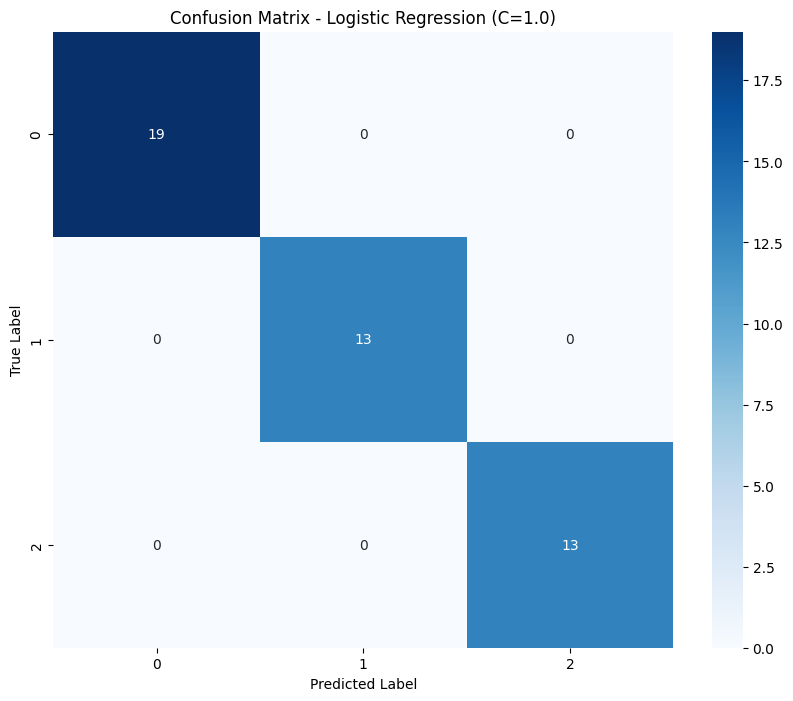

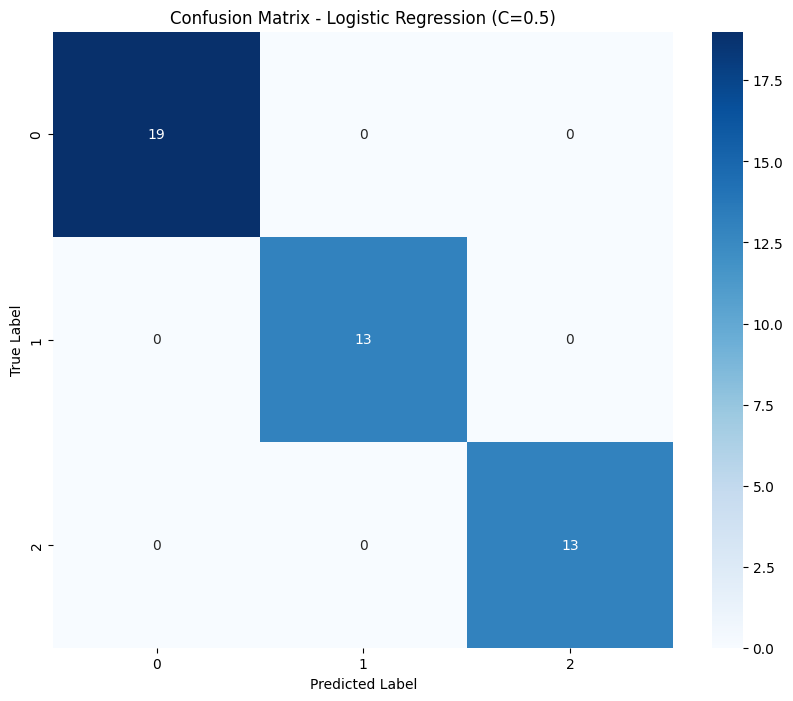

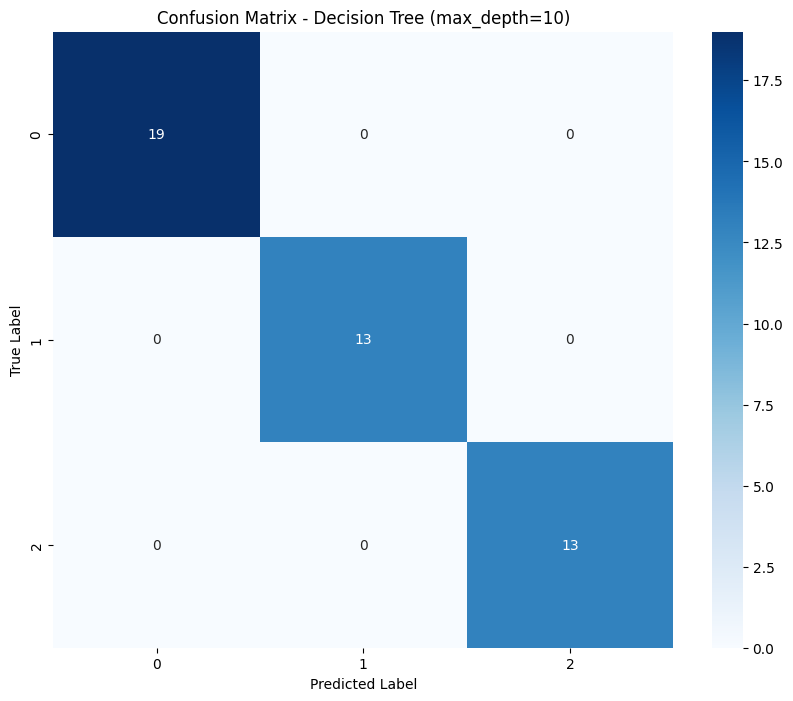

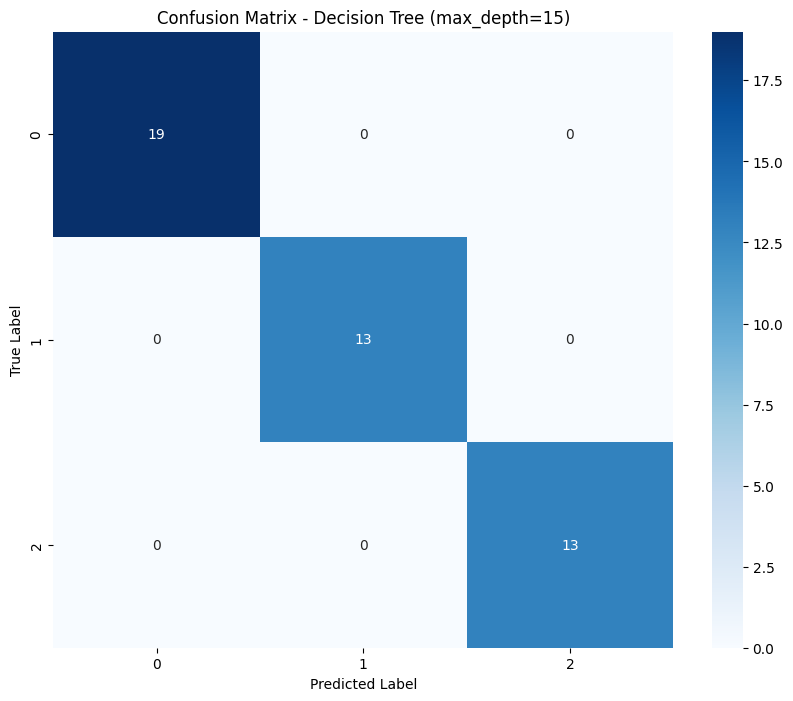

In [26]:
results_df = run_experiments()
  # Логирование df
task.upload_artifact(name='result_df', artifact_object=results_df)